In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout,
    BatchNormalization, Activation,
    GlobalAveragePooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# =========================================================
# SYSTEM CHECK
# =========================================================
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

2026-02-02 03:03:59.898485: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-02 03:04:00.658025: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-02 03:04:03.988379: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow Version: 2.20.0
GPU Available: True


In [2]:
# =========================================================
# CONFIGURATION
# =========================================================
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 50

PUBLIC_DIR = "../Dataset/preprocessed_Public"
SELF_DIR = "../Dataset/SelfCollected_Dataset"

CLASS_NAMES = sorted(os.listdir(PUBLIC_DIR))
NUM_CLASSES = len(CLASS_NAMES)

print("Classes:", CLASS_NAMES)


Classes: ['test', 'train', 'val']


In [3]:
# =========================================================
# CLASS NAMES
# =========================================================
CLASS_NAMES = sorted([
    d for d in os.listdir(os.path.join(PUBLIC_DIR, "train"))
    if os.path.isdir(os.path.join(PUBLIC_DIR, "train", d))
])

NUM_CLASSES = len(CLASS_NAMES)

print("Classes:", CLASS_NAMES)

Classes: ['aluminium', 'paper', 'plastic']


In [4]:
# =========================================================
# DATA GENERATORS 
# =========================================================
train_datagen = ImageDataGenerator(
    rescale=1./255   # Only normalization
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)


In [6]:
# =========================================================
# LOAD DATA FROM DIRECTORIES
# =========================================================
train_gen = train_datagen.flow_from_directory(
    os.path.join(PUBLIC_DIR, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(PUBLIC_DIR, "val"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(SELF_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("\n📊 Dataset Summary")
print("Train samples:", train_gen.samples)
print("Validation samples:", val_gen.samples)
print("Test samples (self):", test_gen.samples)

Found 7512 images belonging to 3 classes.
Found 403 images belonging to 3 classes.
Found 533 images belonging to 3 classes.

📊 Dataset Summary
Train samples: 7512
Validation samples: 403
Test samples (self): 533


In [7]:
# =========================================================
# CNN MODEL (MEMORY SAFE)
# =========================================================
model = Sequential([
    Conv2D(32, 3, padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(64, 3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(128, 3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

print("\n📋 Model Summary")
model.summary()


/home/element944/tf-gpu/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1769972768.873061   93542 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1763 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



📋 Model Summary


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,043 (433.76 KB)

 Trainable params: 110,595 (432.01 KB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
# =========================================================
# CALLBACKS
# =========================================================
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ReduceLROnPlateau(patience=4)
]


In [9]:
# =========================================================
# TRAINING
# =========================================================
print("\n🚀 Training started...\n")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")


🚀 Training started...



Epoch 1/50


2026-02-02 03:06:16.617591: I external/local_xla/xla/service/service.cc:163] XLA service 0x7cbbec0133e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-02 03:06:16.617641: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2026-02-02 03:06:16.731421: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-02 03:06:17.394720: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


  3/470 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.2986 - loss: 1.3758 - precision: 0.3552 - recall: 0.2778   

I0000 00:00:1769972785.693495   94796 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


470/470 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.5899 - loss: 0.8789 - precision: 0.6518 - recall: 0.4751 - val_accuracy: 0.5236 - val_loss: 0.9564 - val_precision: 0.5745 - val_recall: 0.3921 - learning_rate: 1.0000e-04
Epoch 2/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.6853 - loss: 0.7129 - precision: 0.7484 - recall: 0.5932 - val_accuracy: 0.7742 - val_loss: 0.5936 - val_precision: 0.8526 - val_recall: 0.6600 - learning_rate: 1.0000e-04
Epoch 3/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.7173 - loss: 0.6675 - precision: 0.7736 - recall: 0.6342 - val_accuracy: 0.6799 - val_loss: 0.6586 - val_precision: 0.7079 - val_recall: 0.6253 - learning_rate: 1.0000e-04
Epoch 4/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.7347 - loss: 0.6425 - precision: 0.7867 - recall: 0.6592 - val_accuracy: 0.6998 - val_loss: 0.6680 - val_precision: 0.7667 - val_recall: 0.6278 - learning_rate: 1.0000e-04
Epoch 5/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/st

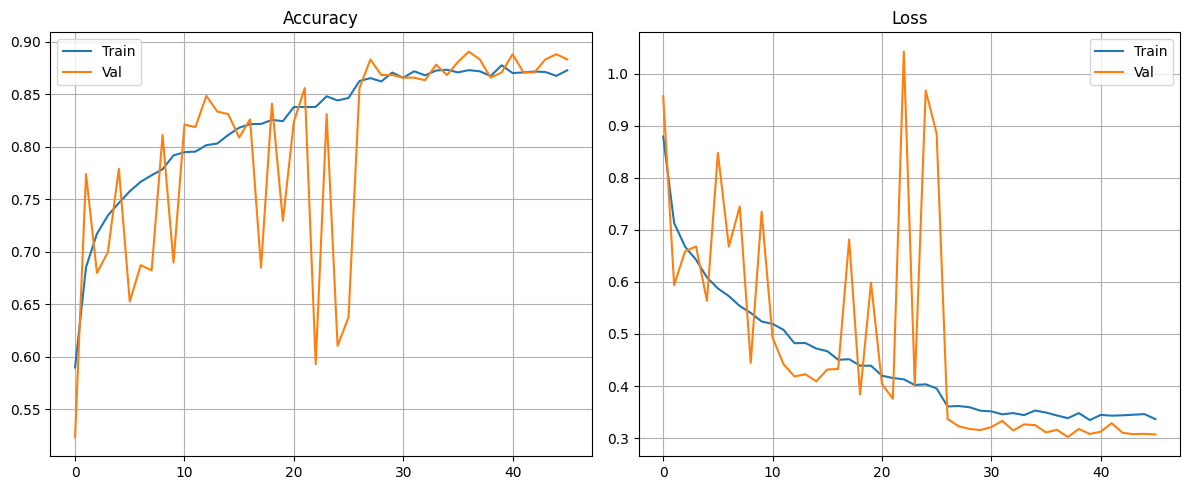

In [10]:
# =========================================================
# TRAINING CURVES
# =========================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


📊 Evaluating on SELF-COLLECTED dataset...
Test Accuracy: 32.83%
Test Precision: 33.90%
Test Recall: 29.83%
Test F1-score: 31.74%
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step

📋 Classification Report
              precision    recall  f1-score   support

   aluminium       0.41      0.30      0.35       148
       paper       0.25      0.46      0.33       151
     plastic       0.41      0.26      0.32       234

    accuracy                           0.33       533
   macro avg       0.36      0.34      0.33       533
weighted avg       0.37      0.33      0.33       533



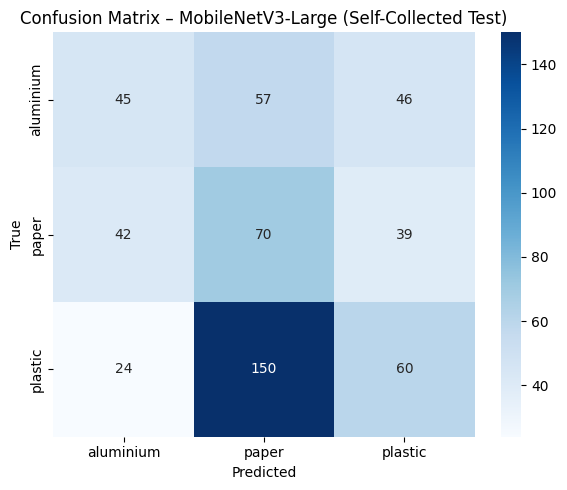

✅ Evaluation completed


In [11]:
# ============================
# EVALUATION ON SELF-COLLECTED DATA
# ============================


print("\n📊 Evaluating on SELF-COLLECTED dataset...")


test_loss, test_acc, test_prec, test_rec = model.evaluate(test_gen, verbose=0)
test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Precision: {test_prec*100:.2f}%")
print(f"Test Recall: {test_rec*100:.2f}%")
print(f"Test F1-score: {test_f1*100:.2f}%")


# Predictions
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes


# Classification report
print("\n📋 Classification Report")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))


# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=test_gen.class_indices.keys(),
yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix – MobileNetV3-Large (Self-Collected Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


print("✅ Evaluation completed")